In [49]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [8]:
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Symbol", "Date"]).reset_index(drop=True)
df["AdjClose"] = df["Close"] * df["Adjustment Factor"]
df["LogReturn"] = np.log(df["AdjClose"] / df["AdjClose"].shift(1))


spy = df[df["Symbol"] == "SPY"].copy()
window = 45

df["LogReturn"] = np.log(df["AdjClose"] / df["AdjClose"].shift(1))
df = df.dropna().reset_index(drop=True)
spy["SPY_LogReturn"] = spy["LogReturn"]
spy["SPY_Var"] = spy["LogReturn"].rolling(window).var()
spy["SPY_Vol"] = spy["LogReturn"].rolling(window).std()
spy["SPY_Mean"] = spy["LogReturn"].rolling(window).mean()
# Spy hurst exponent
spy["SPY_Hurst"] = spy["LogReturn"].rolling(window).apply(
    lambda x: np.polyfit(np.log(range(1, len(x)+1)), np.log(np.cumsum(np.abs(x - np.mean(x)))), 1)[0],
    raw=True
)
spy = spy[["Date", "SPY_Var", "SPY_Vol", "SPY_Mean", "LogReturn", "SPY_Hurst"]].rename(columns={"LogReturn": "SPY_LogReturn"})


merged = df.merge(spy, on="Date", how="left")
merged[["SPY_LogReturn", "SPY_Var", "SPY_Vol", "SPY_Mean", "SPY_Hurst"]] = merged[
    ["SPY_LogReturn", "SPY_Var", "SPY_Vol", "SPY_Mean", "SPY_Hurst"]
].ffill()

In [9]:
merged["Stock_Vol"] = merged.groupby("Symbol")["LogReturn"].transform(lambda x: x.rolling(window).std())
merged["Stock_Mean"] = merged.groupby("Symbol")["LogReturn"].transform(lambda x: x.rolling(window).mean())
merged["LogReturn_demean"] = merged["LogReturn"] - merged["Stock_Mean"]
merged["SPY_demean"] = merged["SPY_LogReturn"] - merged["SPY_Mean"]

merged["Rolling_Corr"] = merged.groupby("Symbol").apply(
    lambda g: g["LogReturn_demean"].rolling(window).corr(g["SPY_demean"])
).reset_index(level=0, drop=True)

merged["Cov"] = merged["Rolling_Corr"] * merged["Stock_Vol"] * merged["SPY_Vol"]
merged["Var_SPY"] = merged["SPY_Var"]
merged["Beta"] = merged["Cov"] / merged["Var_SPY"]
merged = merged.dropna().reset_index(drop=True)

C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\1450352809.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged["Rolling_Corr"] = merged.groupby("Symbol").apply(


In [ ]:
def make_features(df, window=45):
    df["Momentum"] = df["AdjClose"].pct_change(window)
    df["Vol_Ratio"] = df["Stock_Vol"] / df["SPY_Vol"]
    df["Lagged_Beta"] = df["Beta"].shift(1)
    df["Hurst_Exp"] = df["LogReturn"].rolling(window).apply(
        lambda x: np.polyfit(np.log(range(1, len(x)+1)), np.log(np.cumsum(np.abs(x - np.mean(x)))), 1)[0],
        raw=True
    )
    df["Day_of_Year"] = df["Date"].dt.dayofyear
    # Predict future 45-day beta
    df["Beta_Future"] = df["Beta"].shift(-window)
    return df

merged = merged.groupby("Symbol").apply(make_features, window).reset_index(drop=True)
merged = merged.dropna().reset_index(drop=True)


C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\157616616.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged = merged.groupby("Symbol").apply(make_features, window).reset_index(drop=True)


In [51]:
def train_stock_beta_predictor(stock_name):
    stock_df = merged[merged["Symbol"] == stock_name].copy()
    features = ["Rolling_Corr", "Stock_Vol", "SPY_Vol", "Momentum",
                "Vol_Ratio", "Lagged_Beta", "Day_of_Year"]
    
    X = stock_df[features].values
    y = stock_df["Beta_Future"].values

    lookback = 30
    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i - lookback:i])
        y_seq.append(y[i])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    if len(X_seq) < 100:
        return None  # not enough data for training

    split = int(len(X_seq) * 0.7)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    scaler = StandardScaler()
    nsamp, nsteps, nfeat = X_train.shape
    X_train = X_train.reshape(-1, nfeat)
    X_test = X_test.reshape(-1, nfeat)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = X_train.reshape(nsamp, nsteps, nfeat)
    X_test = X_test.reshape(-1, nsteps, nfeat)

    model = Sequential([
        LSTM(64, input_shape=(lookback, nfeat), return_sequences=False),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)
    
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
        # ------------------ Align test dates ------------------
    date_targets = stock_df["Date"].iloc[lookback:].reset_index(drop=True)
    test_dates = date_targets.iloc[split:]
    min_len = min(len(test_dates), len(y_test), len(y_pred))
    test_dates = test_dates.iloc[-min_len:]
    y_test = y_test[-min_len:]
    y_pred = y_pred[-min_len:]

    # ------------------ Plot Beta Prediction Error ------------------
    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, y_test - y_pred, label="Beta Prediction Error", color="purple")
    plt.title(f"{stock_name} Beta Prediction Error (Test Period)")
    plt.xlabel("Date")
    plt.ylabel("Error")
    plt.legend()

    event_dates = ["7/23/2013", "10/28/2013", "1/27/2014", "4/23/2014", "7/22/2014", "10/20/2014",
                   "1/27/2015", "4/27/2015", "7/21/2015", "10/27/2015", "1/26/2016"]
    event_dates = [datetime.strptime(d, "%m/%d/%Y") for d in event_dates]
    for d in event_dates:
        alpha_level = 0.4 if test_dates.min() <= d <= test_dates.max() else 0.1
        plt.axvline(x=d, color="grey", linestyle="--", alpha=alpha_level)
    plt.tight_layout()
    plt.show()

    # ------------------ Actual vs Predicted Beta ------------------
    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, y_test, label="Actual Beta", color="blue")
    plt.plot(test_dates, y_pred, label="Predicted Beta", color="orange")
    plt.title(f"{stock_name} Actual vs Predicted Beta (Test Period)")
    plt.xlabel("Date")
    plt.ylabel("Beta")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ------------------ Diagnostics ------------------
    print(f"{stock_name} Beta Prediction MSE: {mse:.6f}, Correlation: {corr:.3f}")
    print(f"Date range in dataset: {stock_df['Date'].min()} → {stock_df['Date'].max()}")
    print(f"Date range in test period: {test_dates.min()} → {test_dates.max()}")
    print(f"Usable samples: {len(stock_df)}, Train: {len(y_train)}, Test: {len(y_test)}")

    
    return stock_name, mse, np.corrcoef(y_test, y_pred)[0, 1]

In [54]:
stock = "AAPL"
out = train_stock_beta_predictor(stock)



KeyError: 'Beta_Future'

C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\3257069616.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged["Rolling_Corr"] = merged.groupby("Symbol").apply(
C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\3257069616.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged = merged.groupby("Symbol").apply(make_features, window).reset_index(drop=True)
c:\Users\likapichu\anaconda3\Lib\si

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


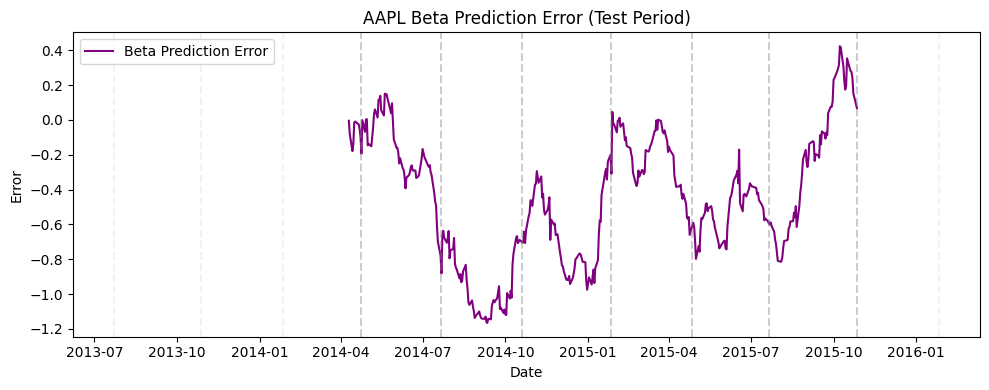

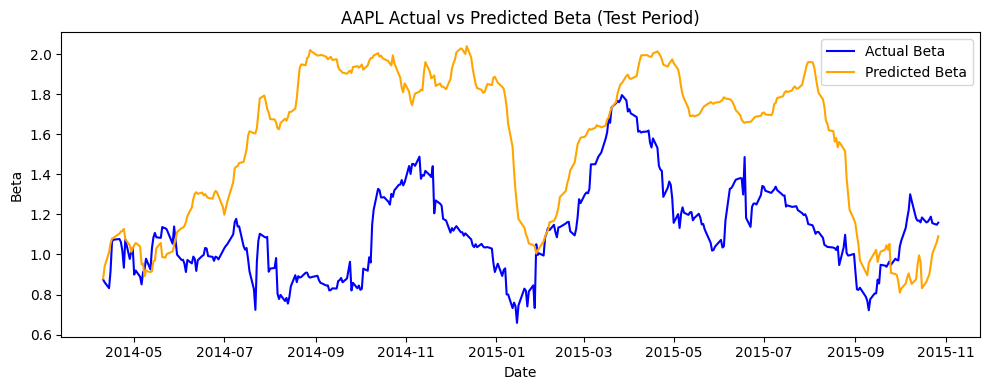

AAPL Beta Prediction MSE: 0.330784, Correlation: 0.342
Date range in dataset: 2010-07-15 00:00:00 → 2015-10-27 00:00:00
Date range in test period: 2014-04-10 00:00:00 → 2015-10-27 00:00:00
Usable samples: 1332, Train: 911, Test: 391


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ============================================================
# 1. LOAD AND PREPARE DATA
# ============================================================
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Symbol", "Date"]).reset_index(drop=True)

df["AdjClose"] = df["Close"] * df["Adjustment Factor"]
df["LogReturn"] = np.log(df["AdjClose"] / df["AdjClose"].shift(1))

window = 45
spy = df[df["Symbol"] == "SPY"].copy()

spy["SPY_Var"] = spy["LogReturn"].rolling(window).var()
spy["SPY_Vol"] = spy["LogReturn"].rolling(window).std()
spy["SPY_Mean"] = spy["LogReturn"].rolling(window).mean()
spy["SPY_Hurst"] = spy["LogReturn"].rolling(window).apply(
    lambda x: np.polyfit(np.log(range(1, len(x)+1)),
                         np.log(np.cumsum(np.abs(x - np.mean(x)))),
                         1)[0],
    raw=True
)
spy = spy[["Date", "LogReturn", "SPY_Var", "SPY_Vol", "SPY_Mean", "SPY_Hurst"]]\
         .rename(columns={"LogReturn": "SPY_LogReturn"})

merged = df.merge(spy, on="Date", how="left")
merged[["SPY_LogReturn", "SPY_Var", "SPY_Vol", "SPY_Mean", "SPY_Hurst"]] = merged[
    ["SPY_LogReturn", "SPY_Var", "SPY_Vol", "SPY_Mean", "SPY_Hurst"]
].ffill()

# ============================================================
# 2. COMPUTE ROLLING BETA FEATURES
# ============================================================
merged["Stock_Vol"] = merged.groupby("Symbol")["LogReturn"].transform(lambda x: x.rolling(window).std())
merged["Stock_Mean"] = merged.groupby("Symbol")["LogReturn"].transform(lambda x: x.rolling(window).mean())

merged["LogReturn_demean"] = merged["LogReturn"] - merged["Stock_Mean"]
merged["SPY_demean"] = merged["SPY_LogReturn"] - merged["SPY_Mean"]

merged["Rolling_Corr"] = merged.groupby("Symbol").apply(
    lambda g: g["LogReturn_demean"].rolling(window).corr(g["SPY_demean"])
).reset_index(level=0, drop=True)

merged["Cov"] = merged["Rolling_Corr"] * merged["Stock_Vol"] * merged["SPY_Vol"]
merged["Var_SPY"] = merged["SPY_Var"]
merged["Beta"] = merged["Cov"] / merged["Var_SPY"]
merged = merged.dropna().reset_index(drop=True)

# ============================================================
# 3. FEATURE ENGINEERING
# ============================================================
def make_features(df, window=45):
    df["Momentum"] = df["AdjClose"].pct_change(window)
    df["Vol_Ratio"] = df["Stock_Vol"] / df["SPY_Vol"]
    df["Lagged_Beta"] = df["Beta"].shift(1)
    df["Hurst_Exp"] = df["LogReturn"].rolling(window).apply(
        lambda x: np.polyfit(np.log(range(1, len(x)+1)),
                             np.log(np.cumsum(np.abs(x - np.mean(x)))),
                             1)[0],
        raw=True
    )
    df["SMA_30"] = df["AdjClose"].rolling(30).mean()
    df["SMA_10"] = df["AdjClose"].rolling(10).mean()
    df["SMA_2"] = df["AdjClose"].rolling(2).mean()
    
    # Previous Stock Beta
    df["Lagged_Beta"] = df["Beta"].shift(1)
    

    df["Volatility"] = df["LogReturn"].rolling(window).std()
    df["Day_of_Year"] = df["Date"].dt.dayofyear
    df["Beta_Future"] = df["Beta"].shift(-window)   # target 45 days ahead
    return df

merged = merged.groupby("Symbol").apply(make_features, window).reset_index(drop=True)
merged = merged.dropna().reset_index(drop=True)

# ============================================================
# 4. TRAIN LSTM AND PLOT FOR A GIVEN STOCK
# ============================================================
def train_stock_beta_predictor(stock_name, merged, window=45, lookback=30):
    stock_df = merged[merged["Symbol"] == stock_name].copy()
    features = ["Rolling_Corr", "Stock_Vol", "SPY_Vol",
                "Momentum", "Vol_Ratio", "Lagged_Beta", "Day_of_Year", "SMA_30", "SMA_10", "SMA_2", "Volatility", "Hurst_Exp"]

    X = stock_df[features].values
    y = stock_df["Beta_Future"].values

    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i - lookback:i])
        y_seq.append(y[i])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    if len(X_seq) < 100:
        print(f"Not enough samples for {stock_name}")
        return None

    split = int(len(X_seq) * 0.7)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    scaler = StandardScaler()
    nsamp, nsteps, nfeat = X_train.shape
    X_train = X_train.reshape(-1, nfeat)
    X_test = X_test.reshape(-1, nfeat)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = X_train.reshape(nsamp, nsteps, nfeat)
    X_test = X_test.reshape(-1, nsteps, nfeat)

    model = Sequential([
        LSTM(64, input_shape=(lookback, nfeat), return_sequences=False),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    corr = np.corrcoef(y_test, y_pred)[0, 1]

    # ------------------ Align test dates ------------------
    date_targets = stock_df["Date"].iloc[lookback:].reset_index(drop=True)
    test_dates = date_targets.iloc[split:]
    min_len = min(len(test_dates), len(y_test), len(y_pred))
    test_dates = test_dates.iloc[-min_len:]
    y_test = y_test[-min_len:]
    y_pred = y_pred[-min_len:]

    # ------------------ Plot Beta Prediction Error ------------------
    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, y_test - y_pred, label="Beta Prediction Error", color="purple")
    plt.title(f"{stock_name} Beta Prediction Error (Test Period)")
    plt.xlabel("Date")
    plt.ylabel("Error")
    plt.legend()

    event_dates = ["7/23/2013", "10/28/2013", "1/27/2014", "4/23/2014",
                   "7/22/2014", "10/20/2014", "1/27/2015", "4/27/2015",
                   "7/21/2015", "10/27/2015", "1/26/2016"]
    event_dates = [datetime.strptime(d, "%m/%d/%Y") for d in event_dates]
    for d in event_dates:
        alpha = 0.4 if test_dates.min() <= d <= test_dates.max() else 0.1
        plt.axvline(x=d, color="grey", linestyle="--", alpha=alpha)
    plt.tight_layout()
    plt.show()

    # ------------------ Actual vs Predicted Beta ------------------
    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, y_test, label="Actual Beta", color="blue")
    plt.plot(test_dates, y_pred, label="Predicted Beta", color="orange")
    plt.title(f"{stock_name} Actual vs Predicted Beta (Test Period)")
    plt.xlabel("Date")
    plt.ylabel("Beta")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ------------------ Diagnostics ------------------
    print(f"{stock_name} Beta Prediction MSE: {mse:.6f}, Correlation: {corr:.3f}")
    print(f"Date range in dataset: {stock_df['Date'].min()} → {stock_df['Date'].max()}")
    print(f"Date range in test period: {test_dates.min()} → {test_dates.max()}")
    print(f"Usable samples: {len(stock_df)}, Train: {len(y_train)}, Test: {len(y_test)}")

    return {"stock": stock_name, "mse": mse, "corr": corr,
            "dates": test_dates, "y_test": y_test, "y_pred": y_pred}

# ============================================================
# 5. RUN FOR A STOCK
# ============================================================
stock = "AAPL"
out = train_stock_beta_predictor(stock, merged)


C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\1214744513.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged["Rolling_Corr"] = merged.groupby("Symbol").apply(
C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\1214744513.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged = merged.groupby("Symbol").apply(make_features).reset_index(drop=True)
c:\Users\likapichu\anaconda3\Lib\site-packa

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


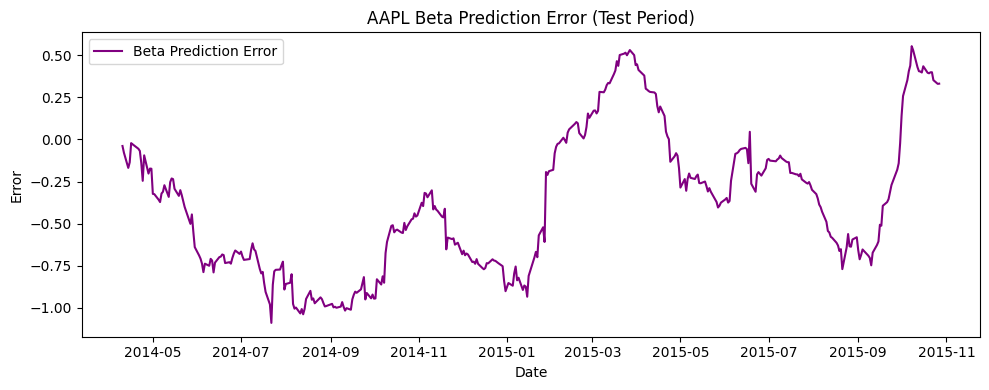

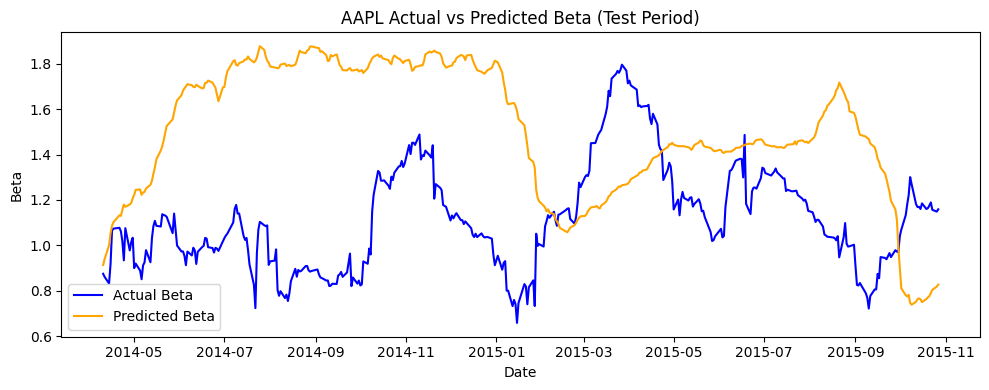

AAPL Beta Prediction MSE: 0.320813, Corr: -0.259, Mean Bias: 0.3838
Date range: 2014-04-10 00:00:00 → 2015-10-27 00:00:00


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ============================================================
# 1. LOAD DATA
# ============================================================
df = pd.read_csv("beta_project_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Symbol", "Date"]).reset_index(drop=True)
df["AdjClose"] = df["Close"] * df["Adjustment Factor"]
df["LogReturn"] = np.log(df["AdjClose"] / df["AdjClose"].shift(1))

window = 45
spy = df[df["Symbol"] == "SPY"].copy()

spy["SPY_Var"] = spy["LogReturn"].rolling(window).var()
spy["SPY_Vol"] = spy["LogReturn"].rolling(window).std()
spy["SPY_Mean"] = spy["LogReturn"].rolling(window).mean()
spy["SPY_Hurst"] = spy["LogReturn"].rolling(window).apply(
    lambda x: np.polyfit(np.log(range(1, len(x)+1)),
                         np.log(np.cumsum(np.abs(x - np.mean(x)))),
                         1)[0],
    raw=True
)
spy = spy[["Date", "LogReturn", "SPY_Var", "SPY_Vol", "SPY_Mean", "SPY_Hurst"]].rename(columns={"LogReturn": "SPY_LogReturn"})

merged = df.merge(spy, on="Date", how="left")
merged[["SPY_LogReturn", "SPY_Var", "SPY_Vol", "SPY_Mean", "SPY_Hurst"]] = merged[
    ["SPY_LogReturn", "SPY_Var", "SPY_Vol", "SPY_Mean", "SPY_Hurst"]
].ffill()

# ============================================================
# 2. ROLLING BETA
# ============================================================
merged["Stock_Vol"] = merged.groupby("Symbol")["LogReturn"].transform(lambda x: x.rolling(window).std())
merged["Stock_Mean"] = merged.groupby("Symbol")["LogReturn"].transform(lambda x: x.rolling(window).mean())
merged["LogReturn_demean"] = merged["LogReturn"] - merged["Stock_Mean"]
merged["SPY_demean"] = merged["SPY_LogReturn"] - merged["SPY_Mean"]

merged["Rolling_Corr"] = merged.groupby("Symbol").apply(
    lambda g: g["LogReturn_demean"].rolling(window).corr(g["SPY_demean"])
).reset_index(level=0, drop=True)

merged["Cov"] = merged["Rolling_Corr"] * merged["Stock_Vol"] * merged["SPY_Vol"]
merged["Var_SPY"] = merged["SPY_Var"]
merged["Beta"] = merged["Cov"] / merged["Var_SPY"]
merged = merged.dropna().reset_index(drop=True)

# ============================================================
# 3. FEATURES
# ============================================================
def make_features(df, window=45):
    df["Momentum"] = df["AdjClose"].pct_change(window)
    df["Vol_Ratio"] = df["Stock_Vol"] / df["SPY_Vol"]
    df["Lagged_Beta"] = df["Beta"].shift(1)
    df["Volatility"] = df["LogReturn"].rolling(window).std()
    df["Day_of_Year"] = df["Date"].dt.dayofyear
    df["Hurst_Exp"] = df["LogReturn"].rolling(window).apply(
        lambda x: np.polyfit(np.log(range(1, len(x)+1)),
                             np.log(np.cumsum(np.abs(x - np.mean(x)))),
                             1)[0],
        raw=True
    )
    df["SMA_30"] = df["AdjClose"].rolling(30).mean()
    df["SMA_10"] = df["AdjClose"].rolling(10).mean()
    df["SMA_2"]  = df["AdjClose"].rolling(2).mean()
    df["Beta_Future"] = df["Beta"].shift(-window)
    return df

merged = merged.groupby("Symbol").apply(make_features).reset_index(drop=True)
merged = merged.dropna().reset_index(drop=True)

# ============================================================
# 4. LSTM TRAINING
# ============================================================
def train_stock_beta_predictor(stock_name, merged, window=45, lookback=30):
    stock_df = merged[merged["Symbol"] == stock_name].copy()

    features = ["Rolling_Corr", "Stock_Vol", "SPY_Vol", "Momentum",
                "Vol_Ratio", "Lagged_Beta", "Day_of_Year",
                "SMA_30", "SMA_10", "SMA_2", "Volatility", "Hurst_Exp"]

    X = stock_df[features].values
    y = stock_df["Beta_Future"].values

    # ---------------- Normalize target (helps with bias) ----------------
    y_mean, y_std = np.mean(y), np.std(y)
    y_norm = (y - y_mean) / y_std

    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i - lookback:i])
        y_seq.append(y_norm[i])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    if len(X_seq) < 100:
        print(f"Not enough samples for {stock_name}")
        return None

    split = int(len(X_seq) * 0.7)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    scaler = StandardScaler()
    nsamp, nsteps, nfeat = X_train.shape
    X_train = X_train.reshape(-1, nfeat)
    X_test = X_test.reshape(-1, nfeat)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = X_train.reshape(nsamp, nsteps, nfeat)
    X_test = X_test.reshape(-1, nsteps, nfeat)

    # ---------------- Model with dropout + bias correction ----------------
    model = Sequential([
        LSTM(64, input_shape=(lookback, nfeat), return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse')
    es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[es])

    y_pred = model.predict(X_test).flatten()

    # ---------------- Denormalize predictions ----------------
    y_test_real = y_test * y_std + y_mean
    y_pred_real = y_pred * y_std + y_mean

    # ---------------- Align test dates ----------------
    date_targets = stock_df["Date"].iloc[lookback:].reset_index(drop=True)
    test_dates = date_targets.iloc[split:]
    min_len = min(len(test_dates), len(y_test_real), len(y_pred_real))
    test_dates = test_dates.iloc[-min_len:]
    y_test_real = y_test_real[-min_len:]
    y_pred_real = y_pred_real[-min_len:]

    # ---------------- Plot ----------------
    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, y_test_real - y_pred_real, label="Beta Prediction Error", color="purple")
    plt.title(f"{stock_name} Beta Prediction Error (Test Period)")
    plt.xlabel("Date")
    plt.ylabel("Error")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, y_test_real, label="Actual Beta", color="blue")
    plt.plot(test_dates, y_pred_real, label="Predicted Beta", color="orange")
    plt.title(f"{stock_name} Actual vs Predicted Beta (Test Period)")
    plt.xlabel("Date")
    plt.ylabel("Beta")
    plt.legend()
    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_test_real, y_pred_real)
    corr = np.corrcoef(y_test_real, y_pred_real)[0, 1]
    bias = np.mean(y_pred_real - y_test_real)

    print(f"{stock_name} Beta Prediction MSE: {mse:.6f}, Corr: {corr:.3f}, Mean Bias: {bias:.4f}")
    print(f"Date range: {test_dates.min()} → {test_dates.max()}")

    return {
        "stock": stock_name,
        "mse": mse,
        "corr": corr,
        "bias": bias,
        "dates": test_dates,
        "y_test": y_test_real,
        "y_pred": y_pred_real
    }

# ============================================================
# 5. RUN FOR STOCK
# ============================================================
stock = "AAPL"
out = train_stock_beta_predictor(stock, merged)


1. Loading data and calculating historical beta...


C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\3302007121.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged["Cov"] = merged.groupby('Symbol').apply(


2. Engineering features...


C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\3302007121.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.full_data = self.full_data.groupby("Symbol").apply(create_features).dropna().reset_index(drop=True)
c:\Users\likapichu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3. Preparing data for AAPL...
4. Training model...
5. Making predictions...
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
6. Evaluating and plotting results...

--- Results for AAPL ---
  Mean Squared Error (MSE): 0.114693
  Correlation: 0.063



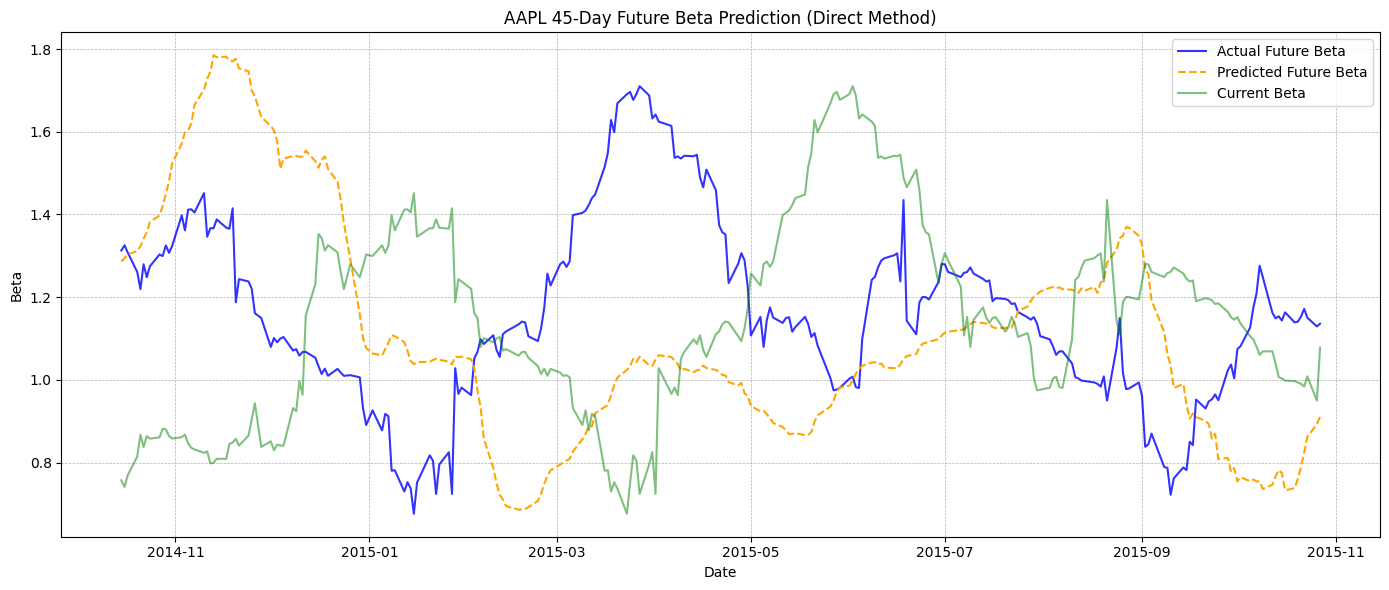

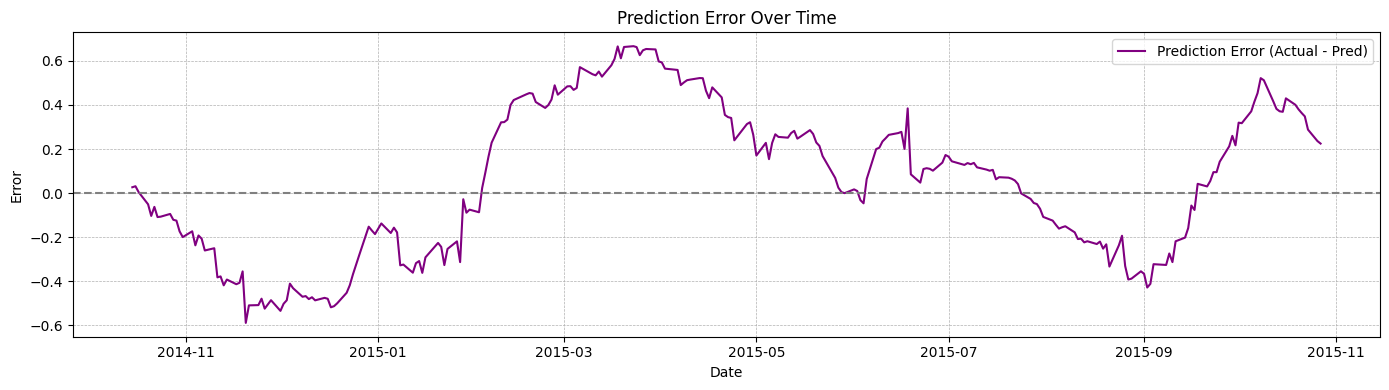

1. Loading data and calculating historical beta...


C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\3302007121.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged["Cov"] = merged.groupby('Symbol').apply(


2. Engineering features...


C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\3302007121.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.full_data = self.full_data.groupby("Symbol").apply(create_features).dropna().reset_index(drop=True)
c:\Users\likapichu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3. Preparing data for BRK.B...
4. Training model...
5. Making predictions...
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
6. Evaluating and plotting results...

--- Results for BRK.B ---
  Mean Squared Error (MSE): 0.026644
  Correlation: 0.138



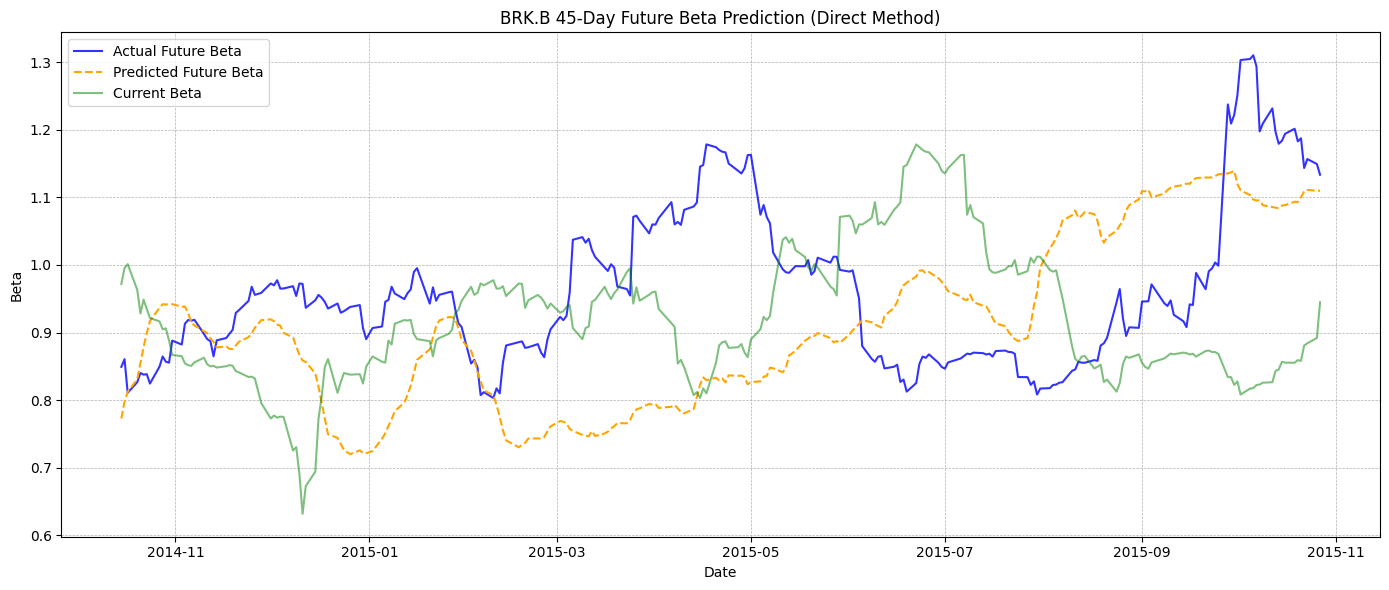

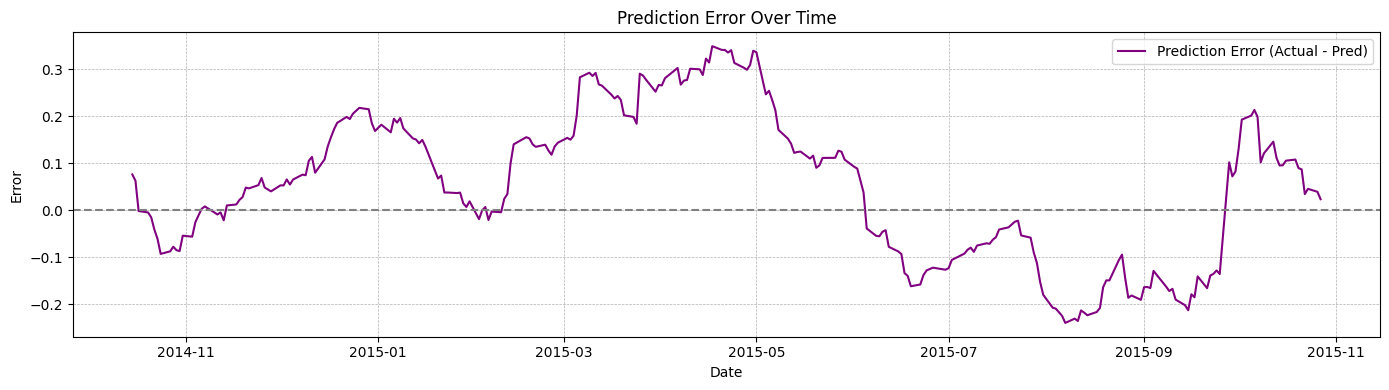

1. Loading data and calculating historical beta...


C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\3302007121.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged["Cov"] = merged.groupby('Symbol').apply(


2. Engineering features...


C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\3302007121.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.full_data = self.full_data.groupby("Symbol").apply(create_features).dropna().reset_index(drop=True)
c:\Users\likapichu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3. Preparing data for JPM...
4. Training model...
5. Making predictions...
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
6. Evaluating and plotting results...

--- Results for JPM ---
  Mean Squared Error (MSE): 0.041266
  Correlation: 0.610



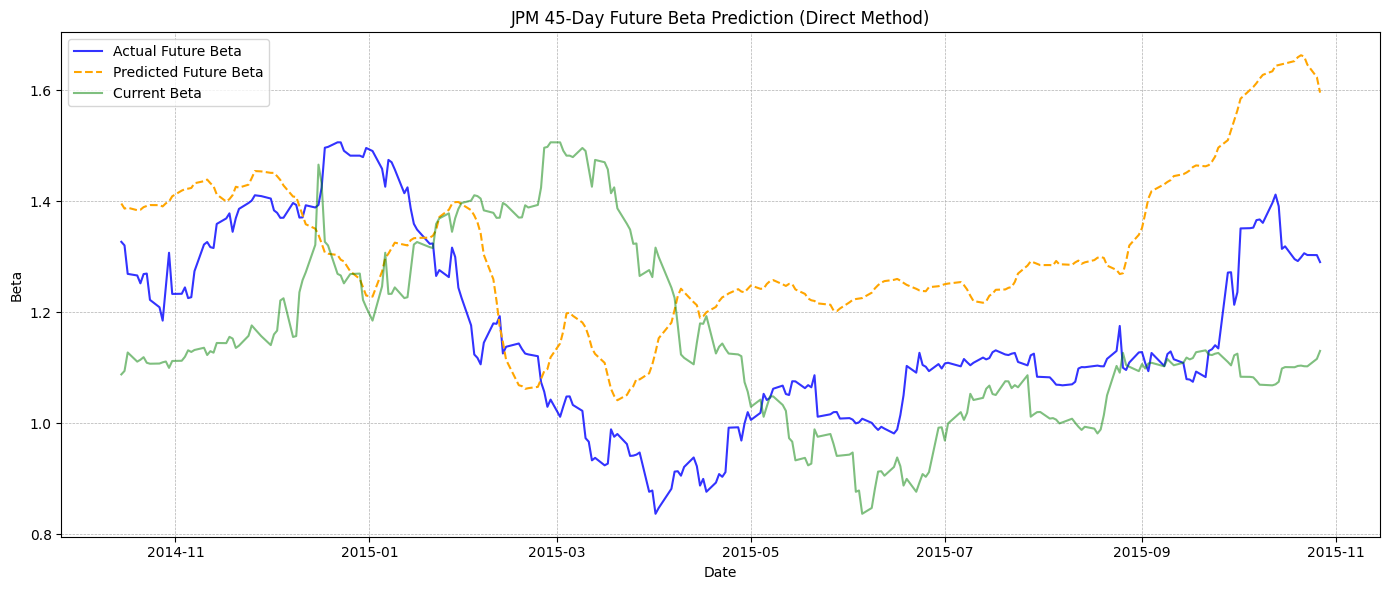

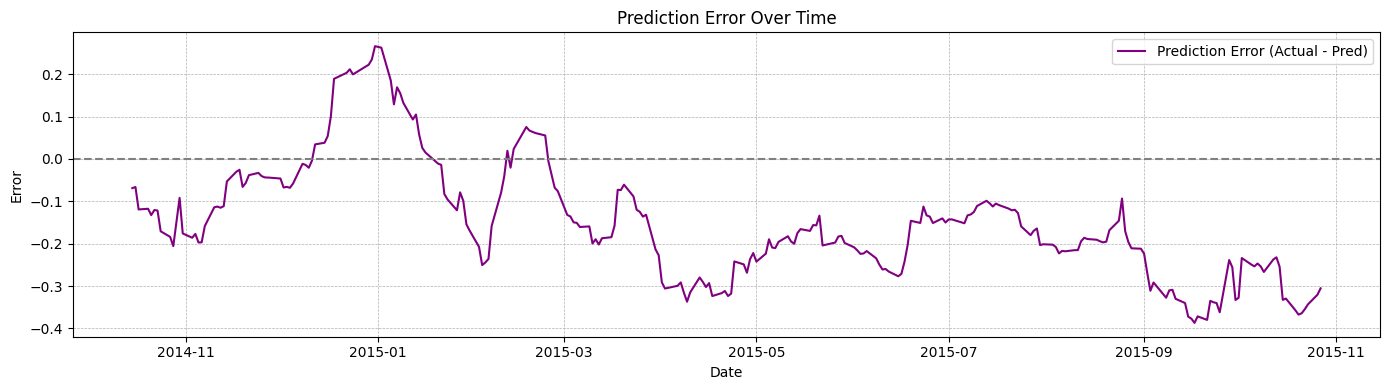

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from typing import Dict, Tuple

# For demonstration, creating a dummy data file if it doesn't exist.
try:
    df_check = pd.read_csv("beta_project_data.csv")
except FileNotFoundError:
    print("Creating dummy 'beta_project_data.csv' for demonstration purposes.")
    with open("beta_project_data.csv", "w") as f:
        f.write("Date,Symbol,Close,Adjustment Factor\n")
        dates = pd.to_datetime('2022-01-01') + pd.to_timedelta(np.arange(1000), 'd')
        for i, date in enumerate(dates):
            date_str = date.strftime('%Y-%m-%d')
            aapl_close = 150 + i * 0.1 + np.random.uniform(-2, 2)
            spy_close = 450 + i * 0.05 + np.random.uniform(-3, 3)
            f.write(f"{date_str},AAPL,{aapl_close:.2f},1.0\n")
            f.write(f"{date_str},SPY,{spy_close:.2f},1.0\n")


class BetaPredictor:
    """
    A refactored class to predict the future beta of a stock by modeling beta directly.
    """
    def __init__(self, data_path: str, window: int = 45, lookback: int = 30, split_ratio: float = 0.8):
        self.data_path = data_path
        self.window = window
        self.lookback = lookback
        self.split_ratio = split_ratio
        
        self.full_data = None
        self.model = None
        self.scalers = {}
        self.results = {}

    def _load_and_calculate_beta(self):
        """Loads data, calculates returns, and computes historical beta."""
        print("1. Loading data and calculating historical beta...")
        df = pd.read_csv(self.data_path)
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values(["Symbol", "Date"]).reset_index(drop=True)
        df["AdjClose"] = df["Close"] * df["Adjustment Factor"]
        df["LogReturn"] = np.log(df["AdjClose"] / df["AdjClose"].shift(1))

        spy = df[df["Symbol"] == "SPY"].copy()
        spy["SPY_Var"] = spy["LogReturn"].rolling(self.window).var()
        spy_market_data = spy[["Date", "LogReturn", "SPY_Var"]].rename(columns={"LogReturn": "SPY_LogReturn"})

        merged = df.merge(spy_market_data, on="Date", how="left").ffill()

        # Calculate rolling covariance using the formula: Cov(X,Y) = E[(X-E[X])(Y-E[Y])]
        merged["Stock_Mean"] = merged.groupby("Symbol")["LogReturn"].transform(lambda x: x.rolling(self.window).mean())
        merged["SPY_Mean"] = merged.groupby("Symbol")["SPY_LogReturn"].transform(lambda x: x.rolling(self.window).mean())
        merged["Cov"] = merged.groupby('Symbol').apply(
            lambda g: (g['LogReturn'] - g['Stock_Mean']) * (g['SPY_LogReturn'] - g['SPY_Mean'])
        ).reset_index(level=0, drop=True).rolling(self.window).mean()
        
        merged["Var_SPY"] = merged["SPY_Var"]
        merged["Beta"] = self._safe_divide(merged["Cov"], merged["Var_SPY"])
        
        self.full_data = merged.dropna().reset_index(drop=True)

    def _engineer_features(self):
        """Engineers features and creates the direct 'Beta_Future' target."""
        print("2. Engineering features...")
        
        def create_features(df_group):
            # Features
            df_group["Momentum"] = df_group["AdjClose"].pct_change(self.window)
            df_group["Volatility"] = df_group["LogReturn"].rolling(self.window).std()
            df_group["SPY_Volatility"] = df_group["SPY_LogReturn"].rolling(self.window).std()
            df_group["Vol_Ratio"] = self._safe_divide(df_group["Volatility"], df_group["SPY_Volatility"])
            df_group["Lagged_Beta"] = df_group["Beta"].shift(1)
            df_group["Day_of_Year"] = df_group["Date"].dt.dayofyear
            # Hurst
            df_group["Hurst_Exp"] = df_group["LogReturn"].rolling(self.window).apply(
                lambda x: np.polyfit(np.log(range(1, len(x)+1)), np.log(np.cumsum(np.abs(x - np.mean(x)))), 1)[0],
                raw=True
            )

            # --- Direct Target Calculation ---
            # This is the key fix: create the future beta target directly.
            df_group['Beta_Future'] = df_group['Beta'].shift(-self.window)
            return df_group

        self.full_data = self.full_data.groupby("Symbol").apply(create_features).dropna().reset_index(drop=True)

    @staticmethod
    def _create_sequences(X_data: np.ndarray, y_data: np.ndarray, lookback: int) -> Tuple[np.ndarray, np.ndarray]:
        """Creates sequences for LSTM model input and corresponding targets."""
        X, y = [], []
        for i in range(lookback, len(X_data)):
            X.append(X_data[i - lookback:i])
            y.append(y_data[i])
        return np.array(X), np.array(y)

    @staticmethod
    def _build_model(input_shape: Tuple[int, int]) -> Sequential:
        """Builds and compiles the Bidirectional LSTM model."""
        model = Sequential([
            Bidirectional(LSTM(64, return_sequences=False, input_shape=input_shape)),
            Dropout(0.3),
            Dense(32, activation="relu"),
            Dense(1) # Linear activation for regression
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
        return model

    @staticmethod
    def _safe_divide(a, b, eps=1e-8, cap=10):
        """Performs division safely, avoiding division by zero and capping the result."""
        ratio = a / (b + eps)
        return np.clip(ratio, -cap, cap)

    def run_workflow(self, stock_symbol: str):
        """
        Executes the entire workflow: data prep, training, prediction, and evaluation.
        
        Args:
            stock_symbol (str): The stock symbol (e.g., 'AAPL') to run the workflow for.
        """
        # --- 1. Data Preparation ---
        self._load_and_calculate_beta()
        self._engineer_features()
        
        print(f"3. Preparing data for {stock_symbol}...")
        df_stock = self.full_data[self.full_data["Symbol"] == stock_symbol].copy()
        if df_stock.empty:
            raise ValueError(f"No data found for symbol: {stock_symbol}")

        # --- 2. Feature and Target Selection ---
        features = ["Beta", "Lagged_Beta", "Momentum", "Volatility", "SPY_Volatility", "Vol_Ratio", "Day_of_Year", "Hurst_Exp"]
        target = "Beta_Future"
        
        X_data = df_stock[features].values
        y_data = df_stock[target].values.reshape(-1, 1)

        X_seq, y_seq = self._create_sequences(X_data, y_data, self.lookback)

        # --- 3. Splitting and Scaling ---
        split_idx = int(len(X_seq) * self.split_ratio)
        X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
        y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

        self.scalers = {'X': StandardScaler(), 'y': StandardScaler()}
        
        X_train = self.scalers['X'].fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_test = self.scalers['X'].transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
        y_train = self.scalers['y'].fit_transform(y_train)

        # --- 4. Model Training ---
        print("4. Training model...")
        self.model = self._build_model((self.lookback, len(features)))
        es = EarlyStopping(patience=10, restore_best_weights=True, monitor='loss')
        self.model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[es])

        # --- 5. Prediction ---
        print("5. Making predictions...")
        pred_scaled = self.model.predict(X_test)
        beta_pred = self.scalers['y'].inverse_transform(pred_scaled).flatten()
        beta_true = y_test.flatten() # True values are already in the correct (non-scaled) form

        # --- 6. Evaluation and Plotting ---
        print("6. Evaluating and plotting results...")
        dates = df_stock["Date"].iloc[self.lookback + split_idx:]
        self._plot_results(dates, beta_true, beta_pred, stock_symbol)

    def _plot_results(self, dates: pd.Series, true: np.ndarray, pred: np.ndarray, symbol: str):
        """Calculates metrics and plots the prediction results."""
        mse = mean_squared_error(true, pred)
        corr = np.corrcoef(true, pred)[0, 1]
        
        print(f"\n--- Results for {symbol} ---")
        print(f"  Mean Squared Error (MSE): {mse:.6f}")
        print(f"  Correlation: {corr:.3f}\n")

        plt.figure(figsize=(14, 6))
        plt.plot(dates, true, label="Actual Future Beta", color="blue", alpha=0.8)
        plt.plot(dates, pred, label="Predicted Future Beta", color="orange", linestyle='--')
        # plot raw spy 
        plt.plot(dates, self.full_data[self.full_data["Symbol"] == symbol]["Beta"].iloc[-len(dates):], label="Current Beta", color="green", alpha=0.5)
        
        plt.title(f"{symbol} 45-Day Future Beta Prediction (Direct Method)")
        plt.xlabel("Date"); plt.ylabel("Beta"); plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout(); plt.show()
        

        plt.figure(figsize=(14, 4))
        plt.plot(dates, true - pred, color="purple", label='Prediction Error (Actual - Pred)')
        plt.axhline(0, color='grey', linestyle='--'); plt.title("Prediction Error Over Time")
        plt.xlabel("Date"); plt.ylabel("Error"); plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout(); plt.show()
        
        

# --- Main Execution ---
if __name__ == "__main__":
    predictor = BetaPredictor(data_path="beta_project_data.csv")
    predictor.run_workflow(stock_symbol="AAPL")
    predictor.run_workflow(stock_symbol="BRK.B")
    predictor.run_workflow(stock_symbol="JPM")

1. Loading data and calculating historical beta...


C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\2797597533.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cov = merged.groupby('Symbol').apply(


2. Engineering features...


C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\2797597533.py:83: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.full_data = self.full_data.groupby("Symbol").apply(create_features).dropna().reset_index(drop=True)


3. Preparing data for AAPL...
4. Training XGBoost model...
5. Making predictions...
6. Evaluating and plotting results...

--- Results for AAPL (XGBoost) ---
  Mean Squared Error (MSE): 0.176862
  Correlation: -0.143



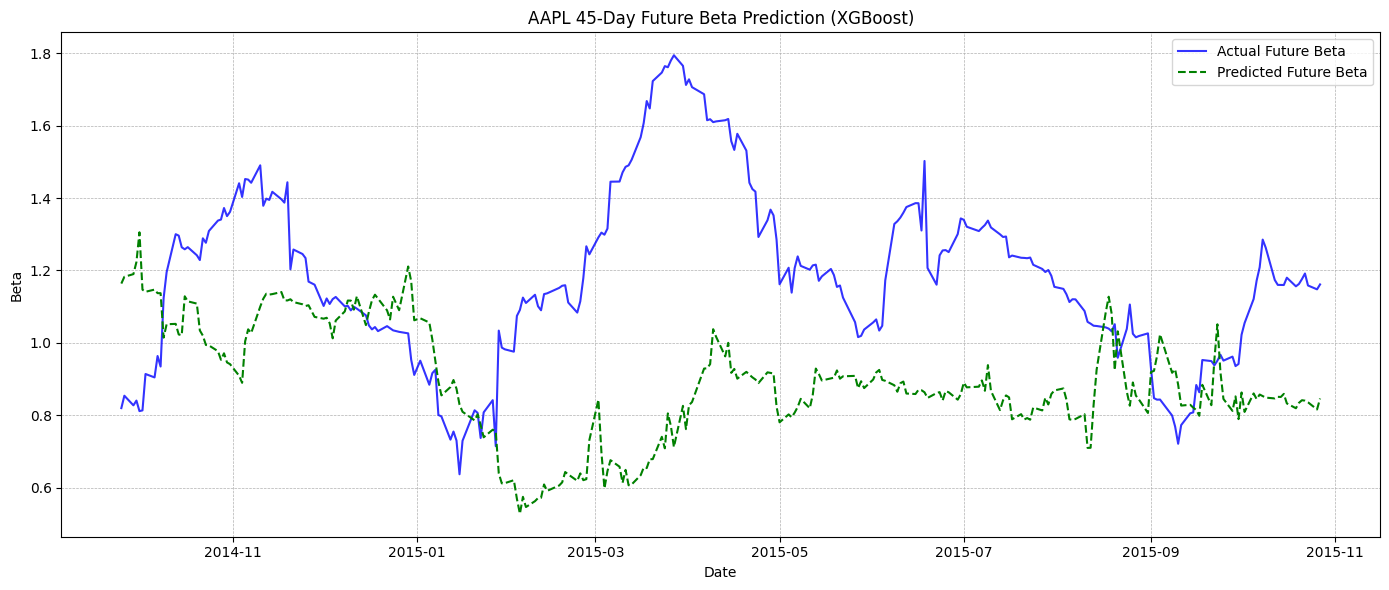

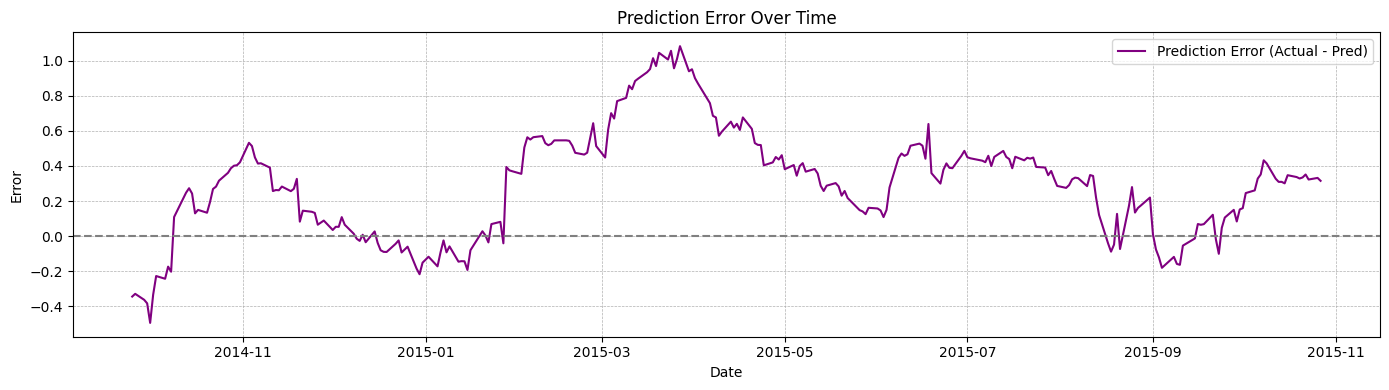

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from typing import Tuple

# For demonstration, creating a dummy data file if it doesn't exist.
try:
    df_check = pd.read_csv("beta_project_data.csv")
except FileNotFoundError:
    print("Creating dummy 'beta_project_data.csv' for demonstration purposes.")
    with open("beta_project_data.csv", "w") as f:
        f.write("Date,Symbol,Close,Adjustment Factor\n")
        dates = pd.to_datetime('2014-01-01') + pd.to_timedelta(np.arange(1000), 'd')
        for i, date in enumerate(dates):
            date_str = date.strftime('%Y-%m-%d')
            aapl_close = 150 + i * 0.1 + np.sin(i/50) * 5 + np.random.uniform(-2, 2)
            spy_close = 450 + i * 0.05 + np.sin(i/30) * 3 + np.random.uniform(-3, 3)
            f.write(f"{date_str},AAPL,{aapl_close:.2f},1.0\n")
            f.write(f"{date_str},SPY,{spy_close:.2f},1.0\n")


class BetaPredictorXGB:
    """
    A class to predict the future beta of a stock using an XGBoost model.
    This version includes a fix for the index alignment error.
    """
    def __init__(self, data_path: str, window: int = 45, lookback: int = 5, split_ratio: float = 0.8):
        self.data_path = data_path
        self.window = window
        self.lookback = lookback
        self.split_ratio = split_ratio
        
        self.full_data = None
        self.model = None
        self.results = {}

    def _load_and_calculate_beta(self):
        """Loads data, calculates returns, and computes historical beta."""
        print("1. Loading data and calculating historical beta...")
        df = pd.read_csv(self.data_path)
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values(["Symbol", "Date"]).reset_index(drop=True)
        df["AdjClose"] = df["Close"] * df["Adjustment Factor"]
        df["LogReturn"] = np.log(df["AdjClose"] / df["AdjClose"].shift(1))

        spy = df[df["Symbol"] == "SPY"].copy()
        spy_market_data = spy[["Date", "LogReturn"]].rename(columns={"LogReturn": "SPY_LogReturn"})

        merged = df.merge(spy_market_data, on="Date", how="left").ffill()

        # --- FIX APPLIED HERE ---
        # Use groupby.apply for a robust rolling covariance calculation that preserves index alignment.
        cov = merged.groupby('Symbol').apply(
            lambda g: g['LogReturn'].rolling(self.window).cov(g['SPY_LogReturn'])
        ).reset_index(level=0, drop=True)
        
        var_spy = merged['SPY_LogReturn'].rolling(self.window).var()
        
        merged["Beta"] = self._safe_divide(cov, var_spy)
        self.full_data = merged.dropna().reset_index(drop=True)

    def _engineer_features(self):
        """Engineers features, including lagged features for the tabular model."""
        print("2. Engineering features...")
        
        def create_features(df_group):
            df_group["Momentum"] = df_group["AdjClose"].pct_change(self.window)
            df_group["Volatility"] = df_group["LogReturn"].rolling(self.window).std()
            df_group["SPY_Volatility"] = df_group["SPY_LogReturn"].rolling(self.window).std()
            df_group["Vol_Ratio"] = self._safe_divide(df_group["Volatility"], df_group["SPY_Volatility"])
            df_group["Day_of_Year"] = df_group["Date"].dt.dayofyear
            
            base_features_to_lag = ["Beta", "Momentum", "Volatility", "Vol_Ratio"]
            for feature in base_features_to_lag:
                for i in range(1, self.lookback + 1):
                    df_group[f"{feature}_lag_{i}"] = df_group[feature].shift(i)

            df_group['Beta_Future'] = df_group['Beta'].shift(-self.window)
            return df_group

        self.full_data = self.full_data.groupby("Symbol").apply(create_features).dropna().reset_index(drop=True)

    def _build_xgb_model(self) -> xgb.XGBRegressor:
        """Builds the XGBoost Regressor model."""
        return xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )

    @staticmethod
    def _safe_divide(a, b, eps=1e-8, cap=10):
        """Performs division safely."""
        ratio = a / (b + eps)
        return np.clip(ratio, -cap, cap)

    def run_workflow(self, stock_symbol: str):
        """Executes the entire workflow."""
        self._load_and_calculate_beta()
        self._engineer_features()
        
        print(f"3. Preparing data for {stock_symbol}...")
        df_stock = self.full_data[self.full_data["Symbol"] == stock_symbol].copy()
        if df_stock.empty:
            raise ValueError(f"No data found for symbol: {stock_symbol}")

        target = "Beta_Future"
        features = [col for col in df_stock.columns if col not in [
            target, "Date", "Symbol", "AdjClose", "Close", 
            "LogReturn", "SPY_LogReturn", "Adjustment Factor"]]
        
        X = df_stock[features]
        y = df_stock[target]

        split_idx = int(len(df_stock) * self.split_ratio)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        print("4. Training XGBoost model...")
        self.model = self._build_xgb_model()
        
        eval_set = [(X_test, y_test)]
        self.model.fit(
            X_train, y_train,
            eval_set=eval_set,
            verbose=False
        )

        print("5. Making predictions...")
        beta_pred = self.model.predict(X_test)
        beta_true = y_test.values

        print("6. Evaluating and plotting results...")
        dates = df_stock["Date"].iloc[split_idx:]
        self._plot_results(dates, beta_true, beta_pred, stock_symbol)

    def _plot_results(self, dates: pd.Series, true: np.ndarray, pred: np.ndarray, symbol: str):
        """Calculates metrics and plots the prediction results."""
        mse = mean_squared_error(true, pred)
        corr = np.corrcoef(true, pred)[0, 1]
        
        print(f"\n--- Results for {symbol} (XGBoost) ---")
        print(f"  Mean Squared Error (MSE): {mse:.6f}")
        print(f"  Correlation: {corr:.3f}\n")

        plt.figure(figsize=(14, 6))
        plt.plot(dates, true, label="Actual Future Beta", color="blue", alpha=0.8)
        plt.plot(dates, pred, label="Predicted Future Beta", color="green", linestyle='--')
        plt.title(f"{symbol} 45-Day Future Beta Prediction (XGBoost)")
        plt.xlabel("Date"); plt.ylabel("Beta"); plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout(); plt.show()

        plt.figure(figsize=(14, 4))
        plt.plot(dates, true - pred, color="purple", label='Prediction Error (Actual - Pred)')
        plt.axhline(0, color='grey', linestyle='--'); plt.title("Prediction Error Over Time")
        plt.xlabel("Date"); plt.ylabel("Error"); plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout(); plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    xgb_predictor = BetaPredictorXGB(data_path="beta_project_data.csv")
    xgb_predictor.run_workflow(stock_symbol="AAPL")

1. Loading data and calculating historical cov/var...


C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\415083697.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cov = merged.groupby('Symbol').apply(


2. Engineering features and future targets...


C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\415083697.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.full_data = self.full_data.groupby("Symbol").apply(create_features).dropna().reset_index(drop=True)


3. Preparing data for AAPL...
4a. Training Covariance model...
4b. Training Market Variance model...
5. Making predictions and combining results...
6. Evaluating and plotting results...

--- Results for AAPL (Dual XGBoost) ---
  Mean Squared Error (MSE): 0.018768
  Correlation: 0.858



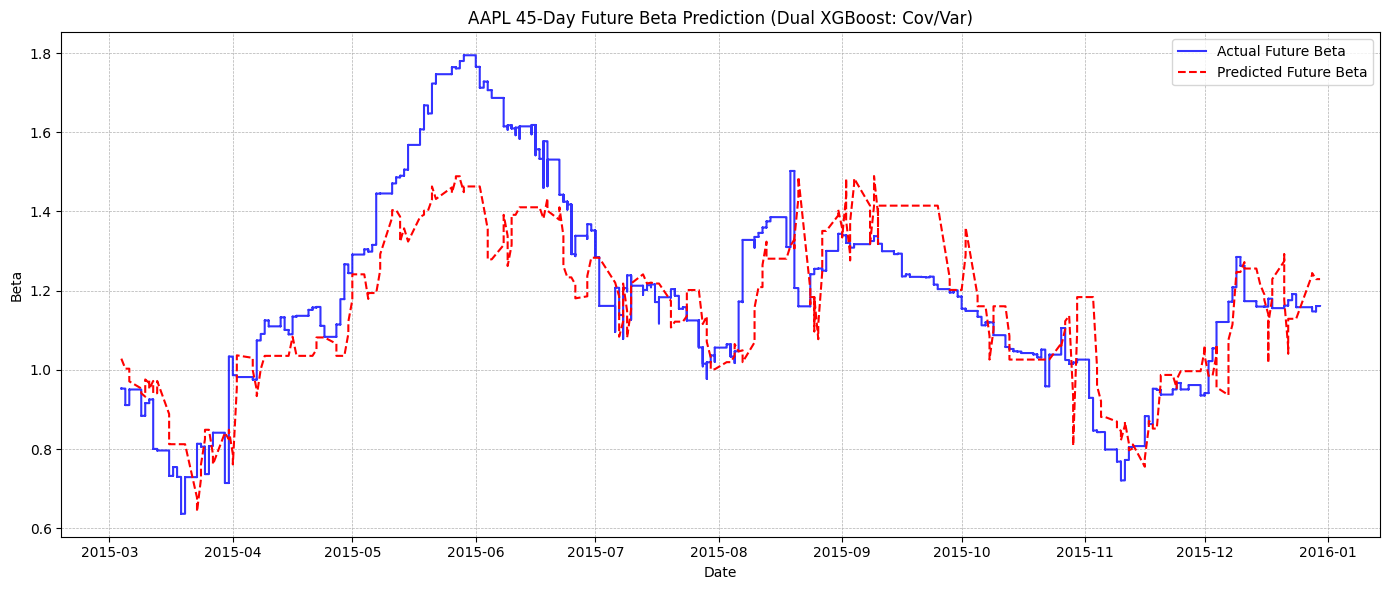

1. Loading data and calculating historical cov/var...


C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\415083697.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cov = merged.groupby('Symbol').apply(


2. Engineering features and future targets...


C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\415083697.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.full_data = self.full_data.groupby("Symbol").apply(create_features).dropna().reset_index(drop=True)


3. Preparing data for JPM...
4a. Training Covariance model...
4b. Training Market Variance model...
5. Making predictions and combining results...
6. Evaluating and plotting results...

--- Results for JPM (Dual XGBoost) ---
  Mean Squared Error (MSE): 0.017762
  Correlation: 0.757



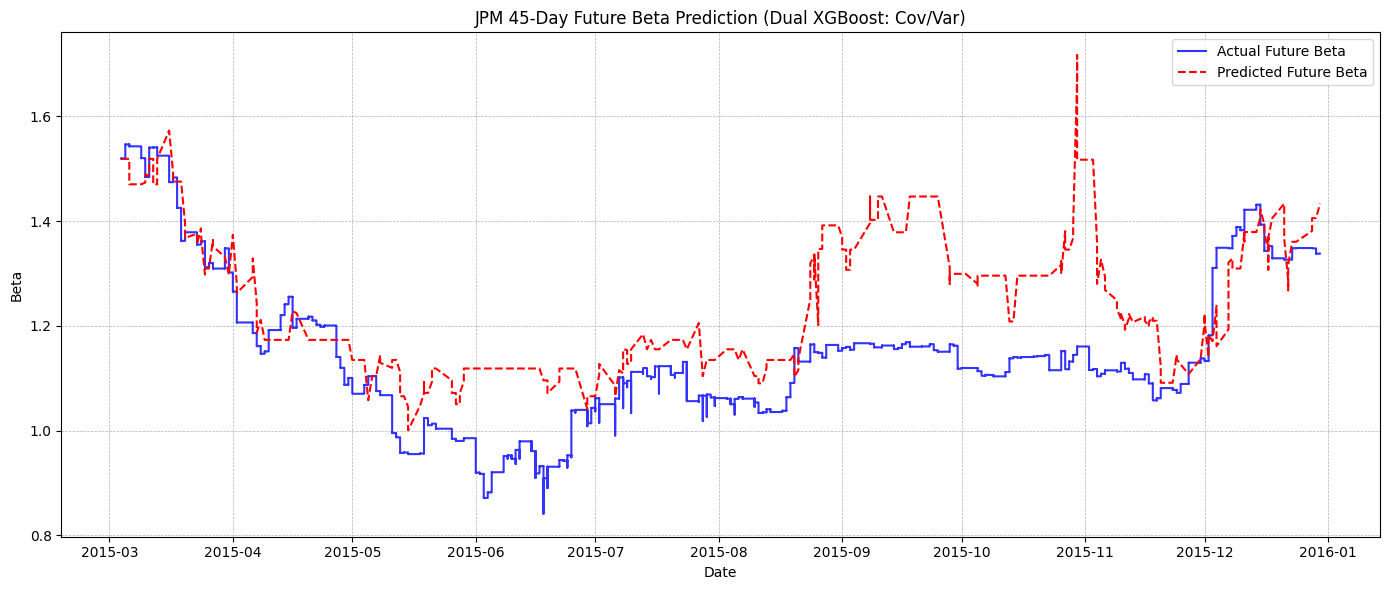

1. Loading data and calculating historical cov/var...


C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\415083697.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cov = merged.groupby('Symbol').apply(


2. Engineering features and future targets...


C:\Users\likapichu\AppData\Local\Temp\ipykernel_624\415083697.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.full_data = self.full_data.groupby("Symbol").apply(create_features).dropna().reset_index(drop=True)


3. Preparing data for TGT...
4a. Training Covariance model...
4b. Training Market Variance model...
5. Making predictions and combining results...
6. Evaluating and plotting results...

--- Results for TGT (Dual XGBoost) ---
  Mean Squared Error (MSE): 0.017590
  Correlation: 0.882



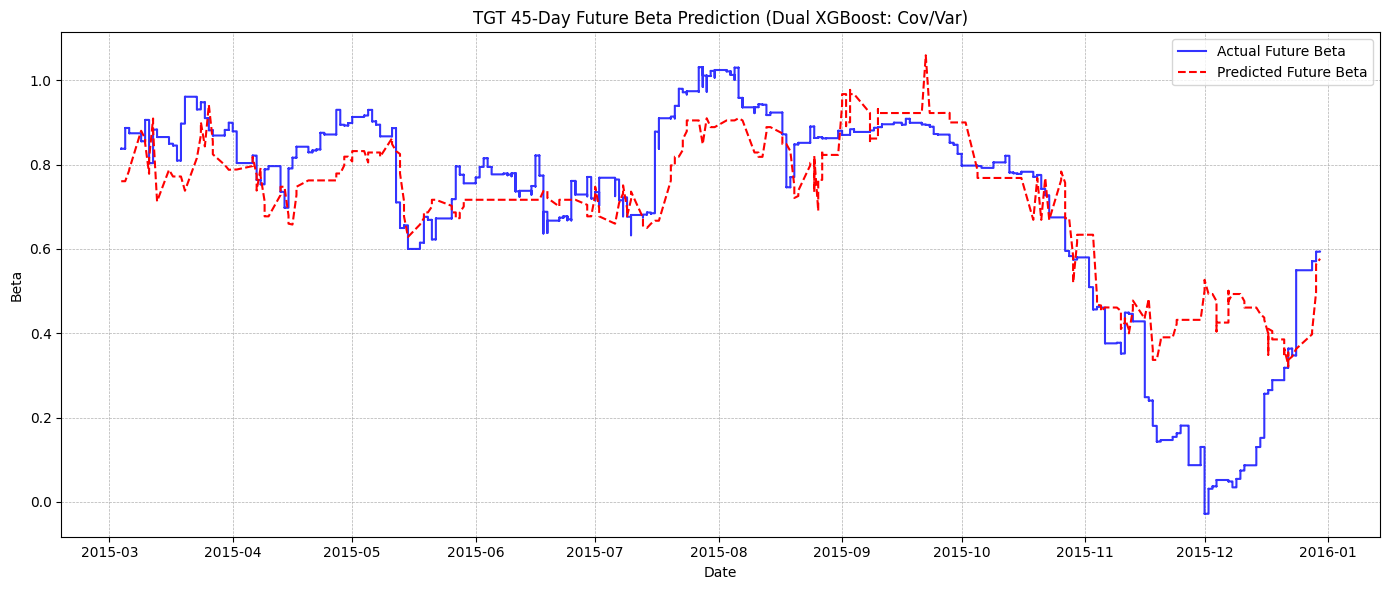

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from typing import Tuple

# For demonstration, creating a dummy data file if it doesn't exist.
df_check = pd.read_csv("beta_project_data.csv")


class BetaPredictorDualXGB:
    """
    Predicts future beta by training two separate XGBoost models: one for covariance
    and one for market variance, then combining their outputs.
    """
    def __init__(self, data_path: str, window: int = 45, lookback: int = 5, split_ratio: float = 0.8):
        self.data_path = data_path
        self.window = window
        self.lookback = lookback
        self.split_ratio = split_ratio
        
        self.full_data = None
        self.model_cov = None
        self.model_var = None
        self.results = {}

    def _prepare_base_data(self):
        """Loads data and calculates historical covariance and variance."""
        print("1. Loading data and calculating historical cov/var...")
        df = pd.read_csv(self.data_path)
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values(["Symbol", "Date"]).reset_index(drop=True)
        df["AdjClose"] = df["Close"] * df["Adjustment Factor"]
        df["LogReturn"] = np.log(df["AdjClose"] / df["AdjClose"].shift(1))

        spy = df[df["Symbol"] == "SPY"].copy()
        spy_market_data = spy[["Date", "LogReturn"]].rename(columns={"LogReturn": "SPY_LogReturn"})
        merged = df.merge(spy_market_data, on="Date", how="left").ffill()

        # Calculate historical covariance and variance
        cov = merged.groupby('Symbol').apply(
            lambda g: g['LogReturn'].rolling(self.window).cov(g['SPY_LogReturn'])
        ).reset_index(level=0, drop=True)
        var_spy = merged['SPY_LogReturn'].rolling(self.window).var()
        
        merged["Cov"] = cov
        merged["Var_SPY"] = var_spy
        merged["Beta"] = self._safe_divide(merged["Cov"], merged["Var_SPY"])
        
        self.full_data = merged.dropna().reset_index(drop=True)

    def _engineer_features_and_targets(self):
        """Engineers features and creates the future cov/var targets."""
        print("2. Engineering features and future targets...")

        # --- Create Future Market Variance Target Safely ---
        # Calculate future variance on the full dataset first to avoid groupby issues
        future_var_spy = self.full_data[['Date', 'Var_SPY']].drop_duplicates().sort_values('Date')
        future_var_spy['Var_SPY_Future'] = future_var_spy['Var_SPY'].shift(-self.window)
        
        # Merge this correct future target back into the main frame
        self.full_data = self.full_data.merge(future_var_spy[['Date', 'Var_SPY_Future']], on='Date', how='left')

        def create_features(df_group):
            # Base features
            df_group["Momentum"] = df_group["AdjClose"].pct_change(self.window)
            df_group["Volatility"] = df_group["LogReturn"].rolling(self.window).std()
            df_group["SPY_Volatility"] = df_group["SPY_LogReturn"].rolling(self.window).std()
            df_group["Vol_Ratio"] = self._safe_divide(df_group["Volatility"], df_group["SPY_Volatility"])
            
            # Lagged features
            features_to_lag = ["Beta", "Cov", "Var_SPY", "Momentum", "Volatility", "SPY_Volatility"]
            for feature in features_to_lag:
                for i in range(1, self.lookback + 1):
                    df_group[f"{feature}_lag_{i}"] = df_group[feature].shift(i)

            # Future covariance target (safe within groupby)
            df_group['Cov_Future'] = df_group['Cov'].shift(-self.window)
            return df_group

        self.full_data = self.full_data.groupby("Symbol").apply(create_features).dropna().reset_index(drop=True)

    def _build_xgb_model(self) -> xgb.XGBRegressor:
        """Builds a standard XGBoost Regressor model."""
        return xgb.XGBRegressor(
            objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,
            max_depth=5, subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1
        )

    @staticmethod
    def _safe_divide(a, b, eps=1e-8, cap=10):
        """Performs division safely."""
        return np.clip(a / (b + eps), -cap, cap)

    def run_workflow(self, stock_symbol: str):
        """Executes the entire dual-model workflow."""
        self._prepare_base_data()
        self._engineer_features_and_targets()
        
        print(f"3. Preparing data for {stock_symbol}...")
        df_stock = self.full_data[self.full_data["Symbol"] == stock_symbol].copy()
        if df_stock.empty:
            raise ValueError(f"No data found for symbol: {stock_symbol}")

        # --- Define Specialized Feature Sets ---
        # Covariance depends on both stock and market features
        features_cov = [c for c in df_stock.columns if c not in ['Date', 'Symbol', 'Cov_Future', 'Var_SPY_Future', 'AdjClose', 'Close', 'LogReturn', 'SPY_LogReturn', 'Adjustment Factor']]
        # Variance depends ONLY on market features
        features_var = [c for c in features_cov if 'SPY' in c or 'Var_SPY' in c]
        
        # --- Prepare Data for Both Models ---
        X_cov = df_stock[features_cov]
        y_cov = df_stock['Cov_Future']
        X_var = df_stock[features_var]
        y_var = df_stock['Var_SPY_Future']

        split_idx = int(len(df_stock) * self.split_ratio)
        X_train_cov, X_test_cov = X_cov.iloc[:split_idx], X_cov.iloc[split_idx:]
        y_train_cov, y_test_cov = y_cov.iloc[:split_idx], y_cov.iloc[split_idx:]
        X_train_var, X_test_var = X_var.iloc[:split_idx], X_var.iloc[split_idx:]
        y_train_var, y_test_var = y_var.iloc[:split_idx], y_var.iloc[split_idx:]

        # --- Train Models ---
        print("4a. Training Covariance model...")
        self.model_cov = self._build_xgb_model()
        self.model_cov.fit(X_train_cov, y_train_cov, eval_set=[(X_test_cov, y_test_cov)], verbose=False)

        print("4b. Training Market Variance model...")
        self.model_var = self._build_xgb_model()
        self.model_var.fit(X_train_var, y_train_var, eval_set=[(X_test_var, y_test_var)], verbose=False)

        # --- Predict and Combine ---
        print("5. Making predictions and combining results...")
        cov_pred = self.model_cov.predict(X_test_cov)
        var_pred = self.model_var.predict(X_test_var)
        
        beta_pred = self._safe_divide(cov_pred, var_pred)
        beta_true = self._safe_divide(y_test_cov.values, y_test_var.values)

        # --- Evaluate and Plot ---
        print("6. Evaluating and plotting results...")
        dates = df_stock["Date"].iloc[split_idx:]
        self._plot_results(dates, beta_true, beta_pred, stock_symbol)

    def _plot_results(self, dates: pd.Series, true: np.ndarray, pred: np.ndarray, symbol: str):
        """Calculates metrics and plots the prediction results."""
        mse = mean_squared_error(true, pred)
        corr = np.corrcoef(true, pred)[0, 1]
        
        print(f"\n--- Results for {symbol} (Dual XGBoost) ---")
        print(f"  Mean Squared Error (MSE): {mse:.6f}")
        print(f"  Correlation: {corr:.3f}\n")

        plt.figure(figsize=(14, 6))
        plt.plot(dates, true, label="Actual Future Beta", color="blue", alpha=0.8)
        plt.plot(dates, pred, label="Predicted Future Beta", color="red", linestyle='--')
        plt.title(f"{symbol} 45-Day Future Beta Prediction (Dual XGBoost: Cov/Var)")
        plt.xlabel("Date"); plt.ylabel("Beta"); plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout(); plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    dual_xgb_predictor = BetaPredictorDualXGB(data_path="beta_project_data.csv")
    dual_xgb_predictor.run_workflow(stock_symbol="AAPL")
    dual_xgb_predictor.run_workflow(stock_symbol="JPM")
    dual_xgb_predictor.run_workflow(stock_symbol="TGT")

In [ ]:

# ------------------ Align test dates ------------------
date_targets = stock_df["Date"].iloc[lookback:].reset_index(drop=True)
test_dates = date_targets.iloc[split:]
min_len = min(len(test_dates), len(y_test), len(y_pred))
test_dates = test_dates.iloc[-min_len:]
y_test = y_test[-min_len:]
y_pred = y_pred[-min_len:]

# ------------------ Plot Beta Prediction Error ------------------
plt.figure(figsize=(10, 4))
plt.plot(test_dates, y_test - y_pred, label="Beta Prediction Error", color="purple")
plt.title(f"{stock} Beta Prediction Error (Test Period)")
plt.xlabel("Date")
plt.ylabel("Error")
plt.legend()

# ------------------ Event markers ------------------
event_dates = ["7/23/2013", "10/28/2013", "1/27/2014", "4/23/2014", "7/22/2014", "10/20/2014", "1/27/2015", "4/27/2015", "7/21/2015", "10/27/2015", "1/26/2016"]
event_dates = [datetime.strptime(d, "%m/%d/%Y") for d in event_dates]
for d in event_dates:
    alpha_level = 0.4 if test_dates.min() <= d <= test_dates.max() else 0.1
    plt.axvline(x=d, color="grey", linestyle="--", alpha=alpha_level)

plt.tight_layout()
plt.show()

# ------------------ Actual Beta vs Predicted Beta ------------------
plt.figure(figsize=(10, 4))
plt.plot(test_dates, y_test, label="Actual Beta", color="blue")
plt.plot(test_dates, y_pred, label="Predicted Beta", color="orange")
plt.title(f"{stock} Actual vs Predicted Beta (Test Period)")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend()
plt.tight_layout()


# ------------------ Diagnostics ------------------
print(f"Date range in dataset: {stock_df['Date'].min()} → {stock_df['Date'].max()}")
print(f"Date range in test period: {test_dates.min()} → {test_dates.max()}")
print(f"Usable samples: {len(stock_df)}, Train: {len(y_train)}, Test: {len(y_test)}")
